In [156]:
#this method works on time space --> needs an original wf which is not the reconstructed one. What you can do: 1) single wf and single fft 2) taking avg of CORRELATED wfs 
# not ideal for the avg of uncorrelated wfs (avg(fft) != fft(avg)) as you have seen comparing A VS B

In [157]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import fft
from scipy import stats
from scipy.signal import get_window
import glob
import time

def ffts(ys):  #the imput are 2d arrays bc this function computes multiple ffts
    Ys = fft.fft(ys, axis = 1) 
    all_phases = np.angle(Ys)
    
    return Ys, all_phases


def filtering_func(freqs, fft, all_phases, f1, f2): #passing 2D complex numbers as fft
    #average the rows
    abs_fft = np.mean(np.abs(fft), axis = 0)
    phases = np.mean(all_phases, axis = 0)
    valid_indices = np.where((freqs >= f1) & (freqs <= f2) | (freqs >= -f2) & (freqs <= -f1))[0]

    fft_in_range = abs_fft[valid_indices]
    print(f'fft_in_range: {fft_in_range} ')

    peak = np.max(fft_in_range)

    local_peak_indices = np.where(abs_fft[valid_indices] == peak)[0]
    general_peak_indices = valid_indices[local_peak_indices]
    print(f"general_peak_indices: {general_peak_indices}")
    print(f"abs_fft[general_peak_indices]: {abs_fft[general_peak_indices]}")

    peak_f = freqs[general_peak_indices]
    print(f"peak_f: {peak_f}")

    peak_phase = phases[general_peak_indices]
    print(f"peak_phase: {peak_phase}")

    print(f'sum: {np.sum(np.isin(freqs, peak_f))}')
    return general_peak_indices, peak_f, peak_phase

In [158]:
hour = '15.42'
day = '08082024'

In [159]:
file_pattern = f"../../Waveforms/{day}/{day}_{hour}/{day}_{hour}_wf.csv/{day}_{hour}_wf_*.csv"
file_list = glob.glob(file_pattern)

amplitudes_list = []

if not file_list:
    print("No files found for the given pattern.")
else:
    for i, file in enumerate(file_list):
        df = pd.read_csv(file)
        if i == 0:
            print(df.iloc[:, 0])
            print(df.iloc[:, 1])
            times = pd.to_numeric(df.iloc[1:, 0], errors = 'coerce').values
        amplitudes = pd.to_numeric(df.iloc[1:, 1], errors='coerce').values
        amplitudes_list.append(amplitudes)
        
all_amplitudes = np.stack(amplitudes_list, axis = 0)
N = len(times)
print(f"len(times): {N}")
print(f"{times}")

0               (us)
1         0.00000000
2         0.00080000
3         0.00160000
4         0.00240000
            ...     
62500    49.99920067
62501    50.00000067
62502    50.00080067
62503    50.00160067
62504    50.00240067
Name: Time, Length: 62505, dtype: object
0               (mV)
1        -1.96850400
2        -1.57480300
3        -1.18110200
4        -0.78740150
            ...     
62500     0.00000000
62501     0.39370070
62502    -0.39370070
62503    -1.18110200
62504    -1.18110200
Name: Channel D, Length: 62505, dtype: object
len(times): 62504
[0.00000000e+00 8.00000000e-04 1.60000000e-03 ... 5.00008007e+01
 5.00016007e+01 5.00024007e+01]


## FFT

In [160]:
span = times[-1]
print(f"span: {span}") 
f_s = len(times) / span
print(f"f_s = {f_s}")
freqs = fft.fftfreq(len(times), 1/f_s) #window lenght, sample spacing
print(f"last freq: {freqs[-1]}") ##this should be the half of f_s.
print(f"len(freqs): {len(freqs)}")
print(freqs)

span: 50.00240067
f_s = 1250.0199822905822
last freq: -0.019999039778103515
len(freqs): 62504
[ 0.          0.01999904  0.03999808 ... -0.05999712 -0.03999808
 -0.01999904]


In [161]:
Ys, all_phases = ffts(all_amplitudes)

In [162]:
if (N%2 == 0):
    pos_freqs = freqs[:round((N/2))]
    pos_Ys = Ys[:, :round((N/2))]
    pos_all_phases = all_phases[:, :round((N/2))]
    pos_all_amplitudes = all_amplitudes[:, :round((N/2))]
else:
    pos_freqs = freqs[:round((N-1)/2 + 1)]
    pos_magnitudes = Ys[:, :round((N-1)/2 + 1)]
    pos_all_phases = all_phases[:, :round((N-1)/2 + 1)]
    pos_all_amplitudes = all_amplitudes[:, :round((N-1)/2 + 1)]

In [163]:
avg_fft = np.mean(np.abs(pos_Ys), axis = 0) 
n = np.max(avg_fft)
avg_fft_au = avg_fft / n

avg_phases = np.mean(pos_all_phases, axis = 0)

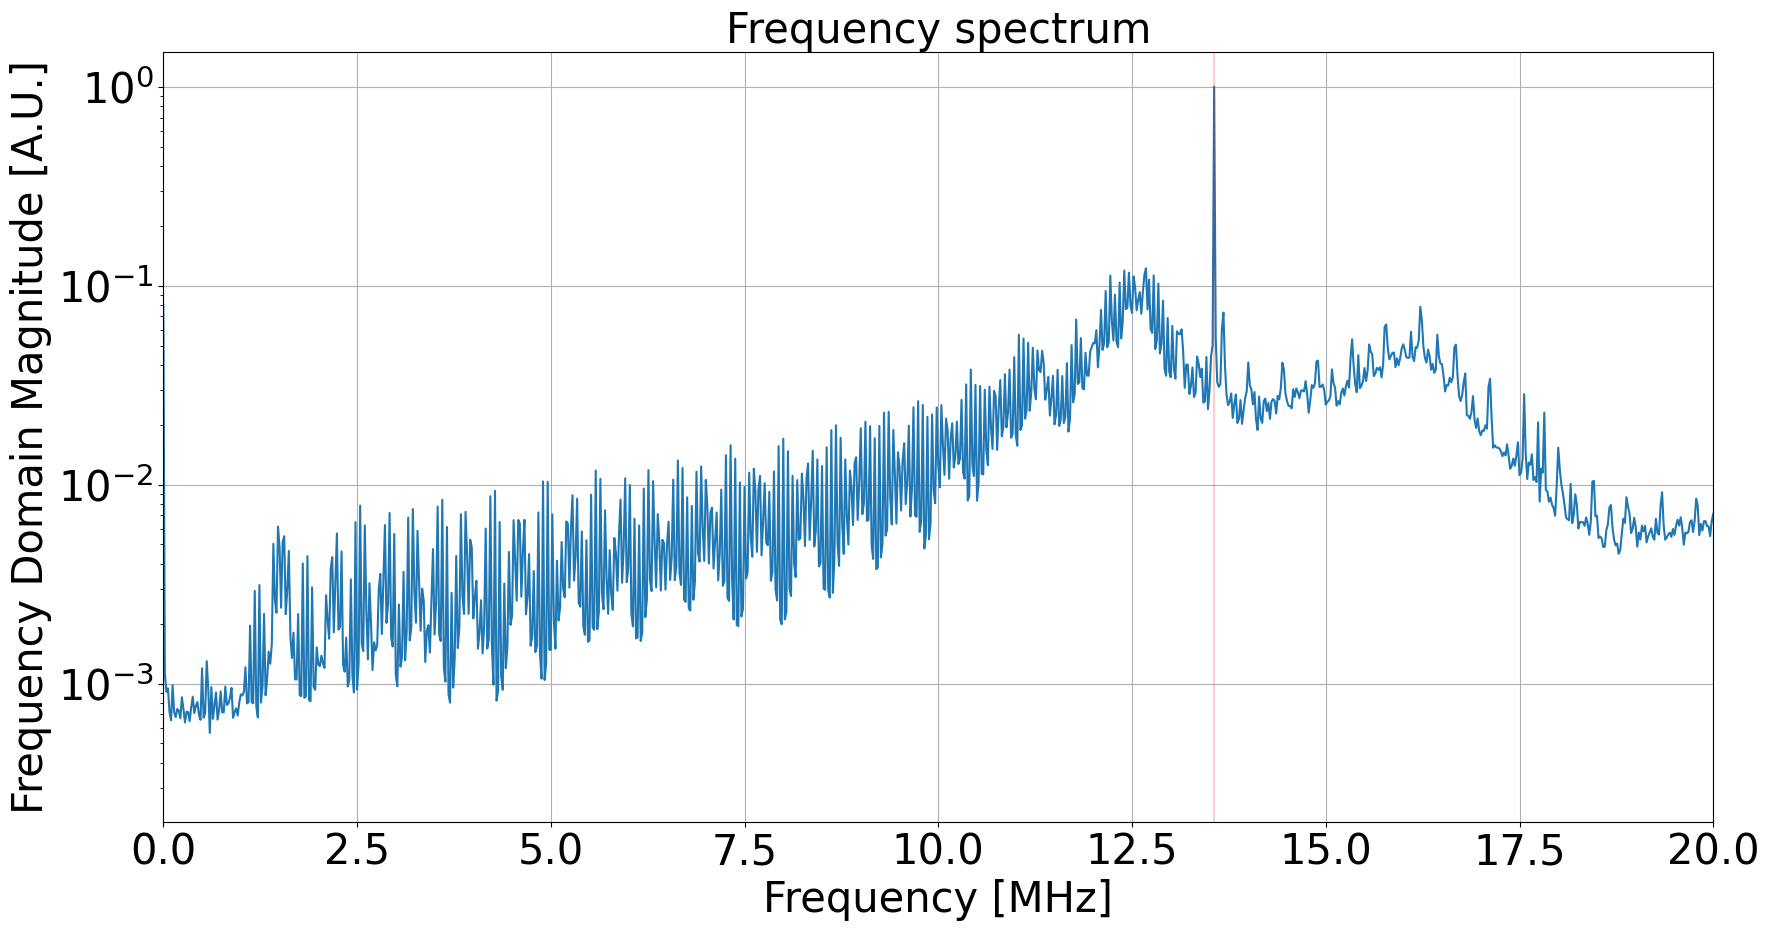

In [164]:
f1 = 0
f2 = 20

plt.figure(figsize=(20, 10))
#plt.errorbar(freqs, avg_fft_au, yerr = stds_fft, fmt='o', markersize = 2, ecolor='red', capsize = 3, capthick=1, elinewidth=1)
plt.plot(pos_freqs, avg_fft_au)

plt.axvline(13.55934897, color = 'red', alpha = 0.2)
plt.title('Frequency spectrum', fontsize = 30)
plt.xlabel('Frequency [MHz]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Frequency Domain Magnitude [A.U.]', fontsize = 30)
plt.yticks(fontsize = 30)
plt.semilogy()
plt.grid(True)
plt.xlim(f1, f2)
#plt.semilogx()

#plt.savefig("250724_17.23/fft.pdf", format = "pdf", bbox_inches="tight")
plt.show()

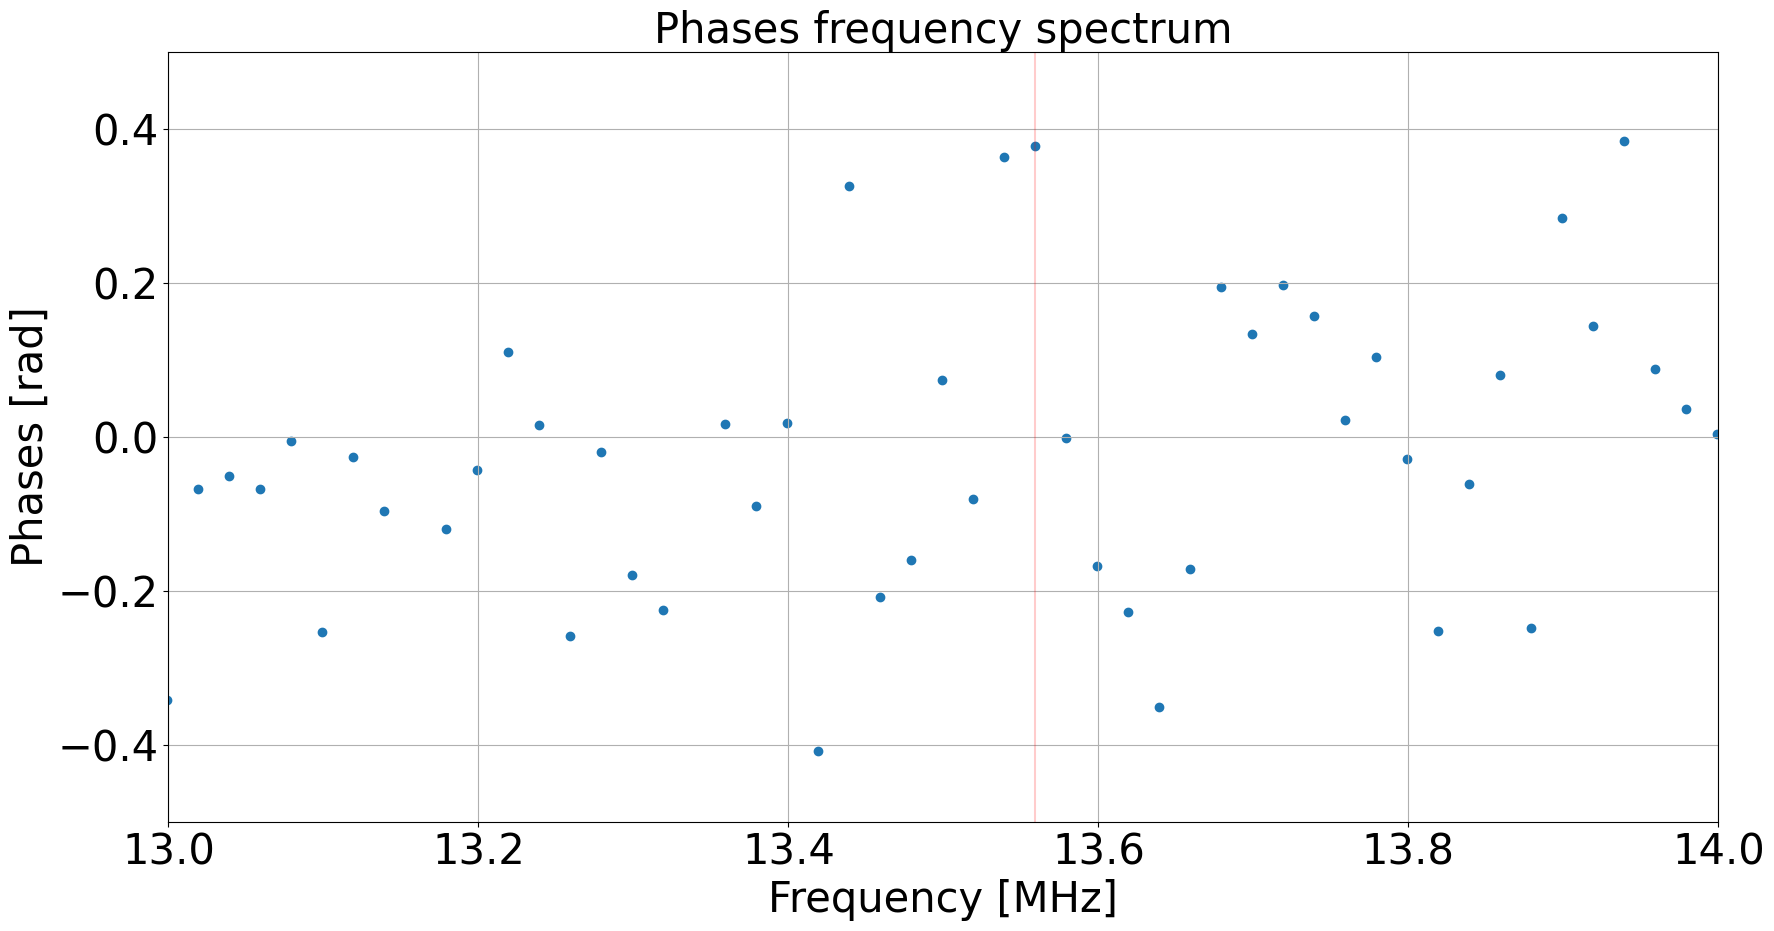

In [165]:
plt.figure(figsize=(20, 10))
#plt.errorbar(freqs, avg_fft_au, yerr = stds_fft, fmt='o', markersize = 2, ecolor='red', capsize = 3, capthick=1, elinewidth=1)
plt.scatter(pos_freqs, avg_phases)

plt.axvline(13.55934897, color = 'red', alpha = 0.2)
plt.title('Phases frequency spectrum', fontsize = 30)
plt.xlabel('Frequency [MHz]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Phases [rad]', fontsize = 30)
plt.yticks(fontsize = 30)
plt.grid(True)
plt.ylim(-0.5, 0.5)
plt.xlim(13, 14)
#plt.semilogx()

#plt.savefig("250724_17.23/fft.pdf", format = "pdf", bbox_inches="tight")
plt.show()

In [166]:
print(avg_phases[np.where(np.isclose(pos_freqs, 13.55934897))]*180/np.pi)

[21.6206586]


## Filtering

In [167]:
peak_indices, peak_f, peak_phases = filtering_func(freqs, Ys, all_phases, f1, f2)

# times_new = np.arange(0, times[-1], 1 / f_s_new)
# print(f"len(times_new): {len(times_new)}")
# print(f"times_new: {times_new}")

# times_new_2 = np.arange(N) / f_s_new
# print(f"len(times_new_2): {len(times_new_2)}")
# print(f"times_new_2: {times_new_2}")

# print(f"f_s: {f_s}")

fft_in_range: [8562.75769291  119.37760201   96.86667995 ...  100.83839713   96.86667995
  119.37760201] 
general_peak_indices: [  678 61826]
abs_fft[general_peak_indices]: [106648.29531659 106648.29531659]
peak_f: [ 13.55934897 -13.55934897]
peak_phase: [ 0.37735168 -0.37735168]
sum: 2


In [168]:
noise_fft = Ys.copy()
mask = np.ones(noise_fft.shape[1], dtype=bool)
mask[peak_indices] = False
noise_fft[:, mask] = complex(0, 0)

#noise_wf = np.sin(peak_f* 2*np.pi * times + peak_phases)

[ 0.          0.01999904  0.03999808 ... -0.05999712 -0.03999808
 -0.01999904]
non zero: 2


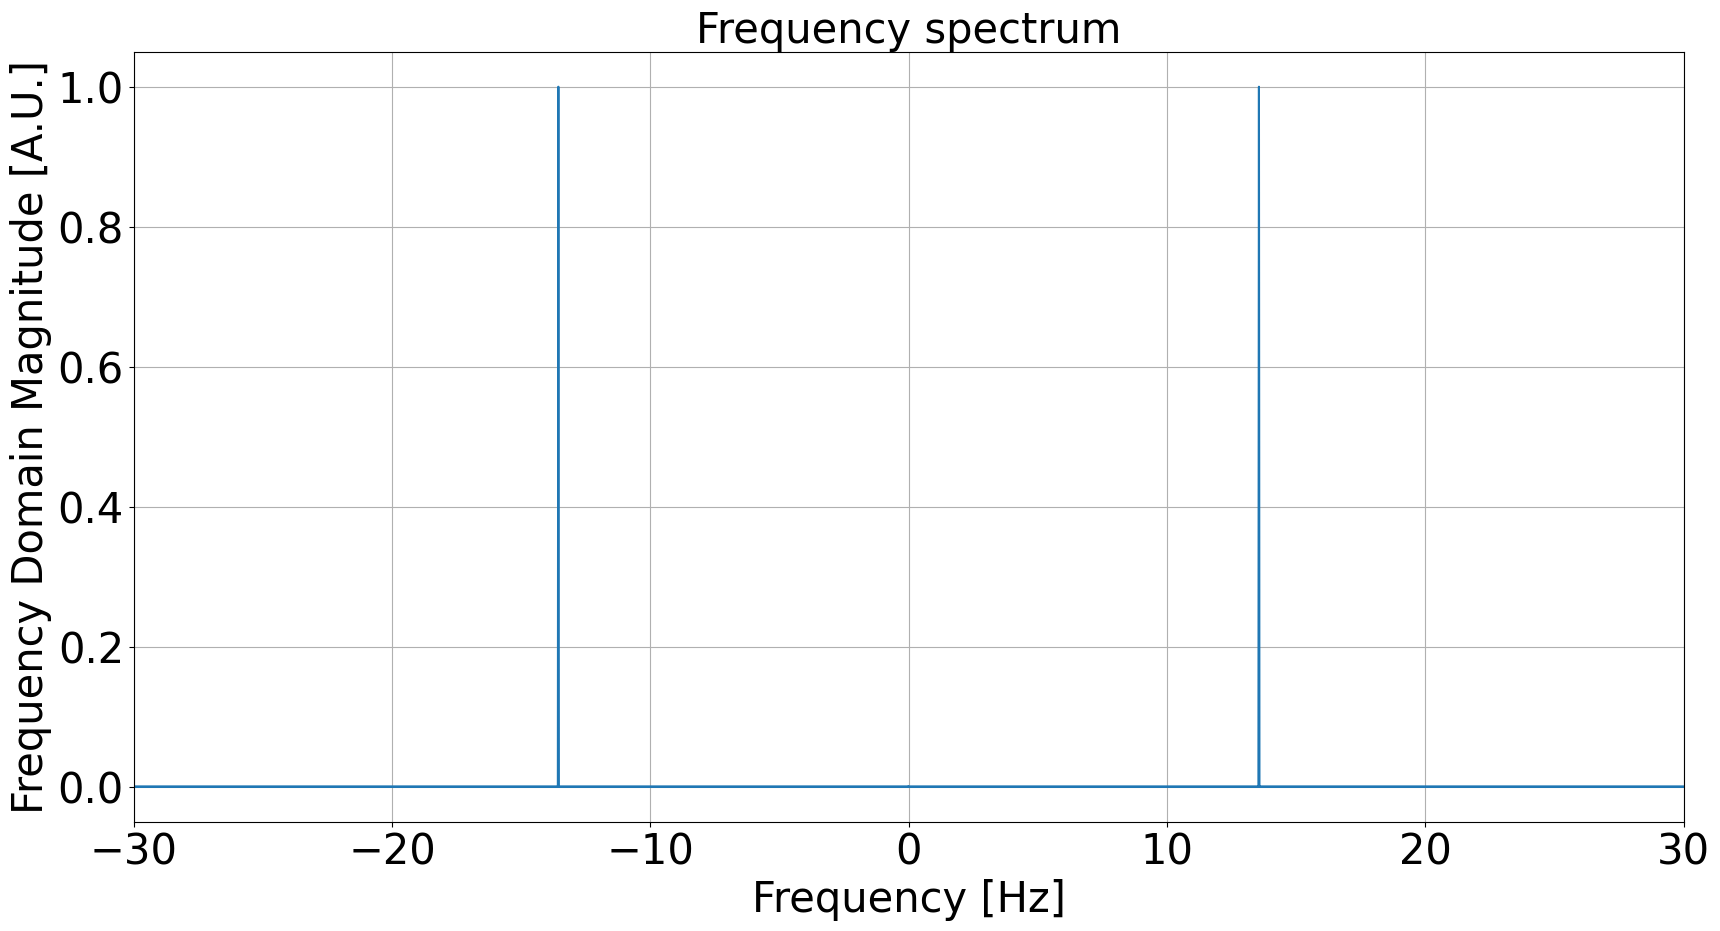

In [169]:
plt.figure(figsize=(20, 10))
plt.plot(freqs, np.mean(np.abs(noise_fft), axis = 0)/n)
plt.title('Frequency spectrum', fontsize = 30)
plt.xlabel('Frequency [Hz]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Frequency Domain Magnitude [A.U.]', fontsize = 30)
plt.yticks(fontsize = 30)
#plt.xlim(- f_s / 2, f_s / 2) #freq of time sampling
plt.xlim(-f2-10, f2+10)
plt.grid(True)
print(freqs)
print(f"non zero: {np.count_nonzero(np.mean(np.abs(noise_fft), axis = 0)/n)}")

#plt.savefig("Results/simple_fft.png", format = "png", bbox_inches="tight")
#plt.savefig("Results/simple_fft.pdf", format = "pdf", bbox_inches="tight")
plt.show()

In [170]:
noise_wf = fft.ifft(noise_fft, axis = 1)
avg_noise_wf = np.mean(noise_wf.real, axis = 0)
#avg_noise_wf -= np.mean(avg_noise_wf)

In [171]:
A = max(avg_noise_wf)
f = peak_f[0]
phi = peak_phases[0]
print(phi*180/np.pi)
coswave = A*np.cos(f*np.pi*2*times + phi)

21.62065859970982


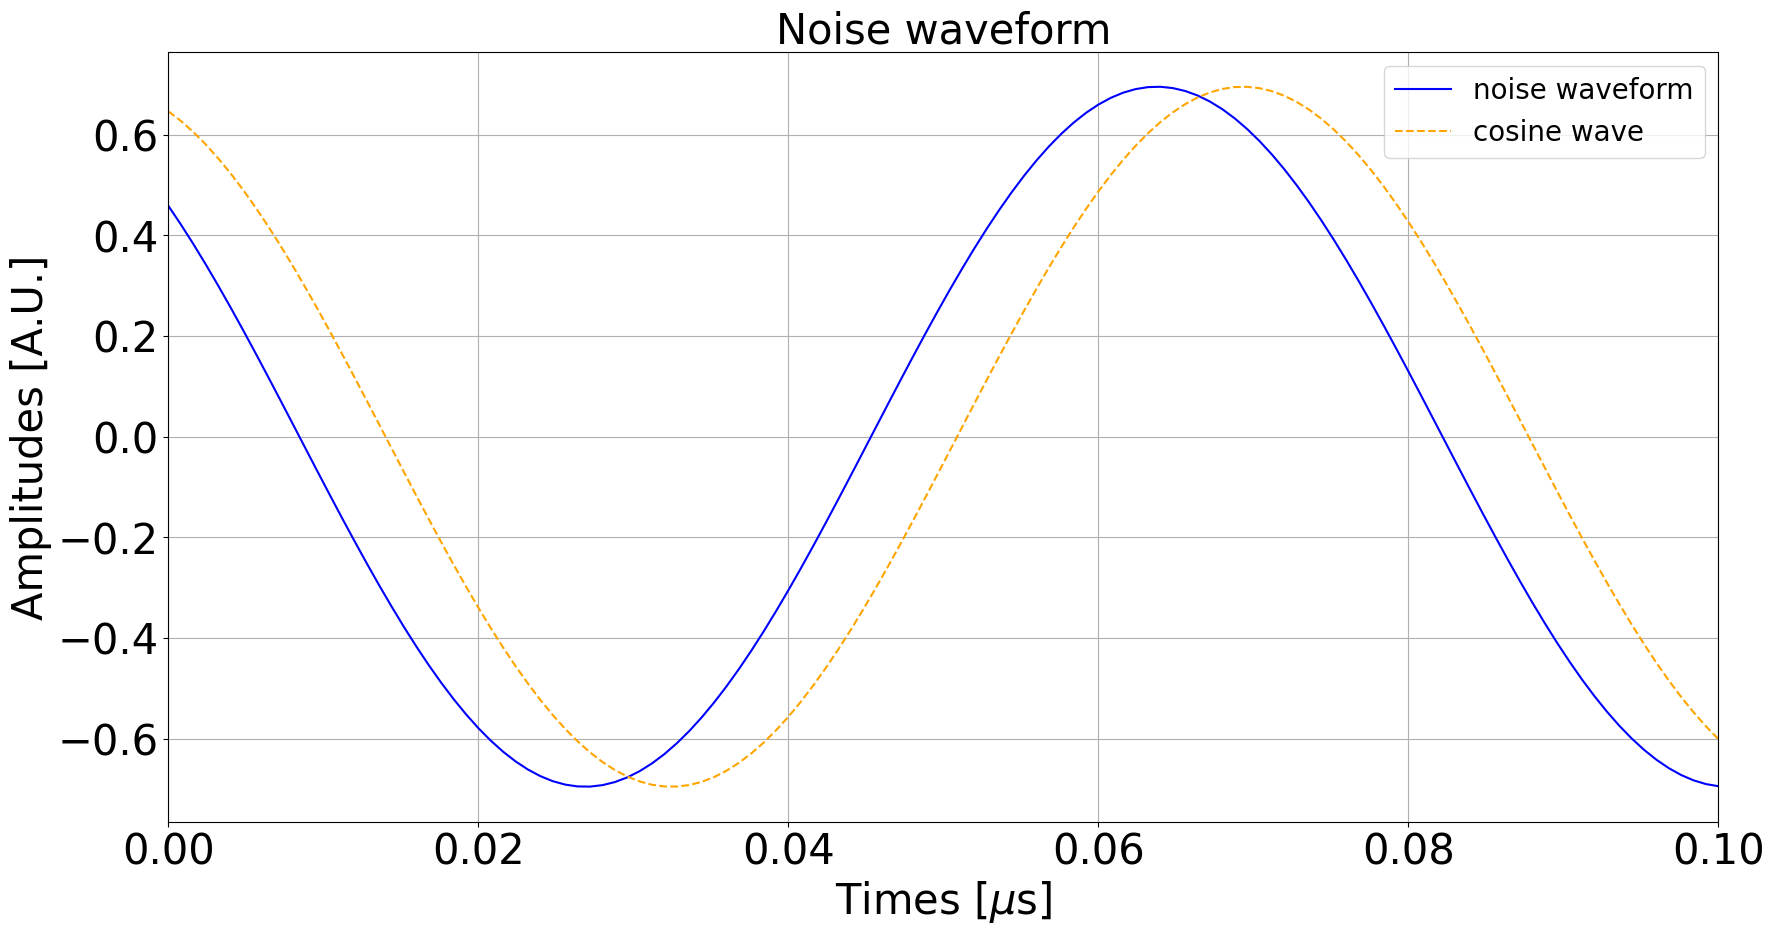

62.69539592010636
declareted phase: [21.6206586] = 21.62065859970982
real phase: [68.3793414]


In [172]:
plt.figure(figsize=(20, 10))
#plt.errorbar(freqs, avg_fft_au, yerr = stds_fft, fmt='o', markersize = 2, ecolor='red', capsize = 3, capthick=1, elinewidth=1)
plt.plot(times, avg_noise_wf, color = 'blue', label = 'noise waveform')
plt.plot(times, coswave, linestyle = '--', color = 'orange', label = 'cosine wave')

plt.title('Noise waveform', fontsize = 30)
plt.xlabel(r'Times [$\mu$s]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Amplitudes [A.U.]', fontsize = 30)
plt.yticks(fontsize = 30)
plt.grid(True)
plt.xlim(0, 0.1)
plt.legend(loc = 'best', fontsize = 20)

#plt.savefig("250724_17.23/fft.pdf", format = "pdf", bbox_inches="tight")
plt.show()

ifft_phase = np.arccos(avg_noise_wf[0])
print(np.arccos(avg_noise_wf[0])*180/np.pi)

index_peak_phase = np.where(np.isclose(freqs, 13.55934897))[0]
declareted_phase = avg_phases[index_peak_phase]
print(f"declareted phase: {declareted_phase*180/np.pi} = {peak_phases[0]*180/np.pi}")
difference = np.pi/2
real_phase = difference - declareted_phase
print(f"real phase: {(difference - declareted_phase)*180/np.pi}")

theta = (declareted_phase - ifft_phase)


In [173]:
noise_wf_corr = noise_wf*(np.cos(theta) + 1j*np.sin(theta))
avg_noise_wf_corr = np.mean(noise_wf_corr.real, axis = 0)

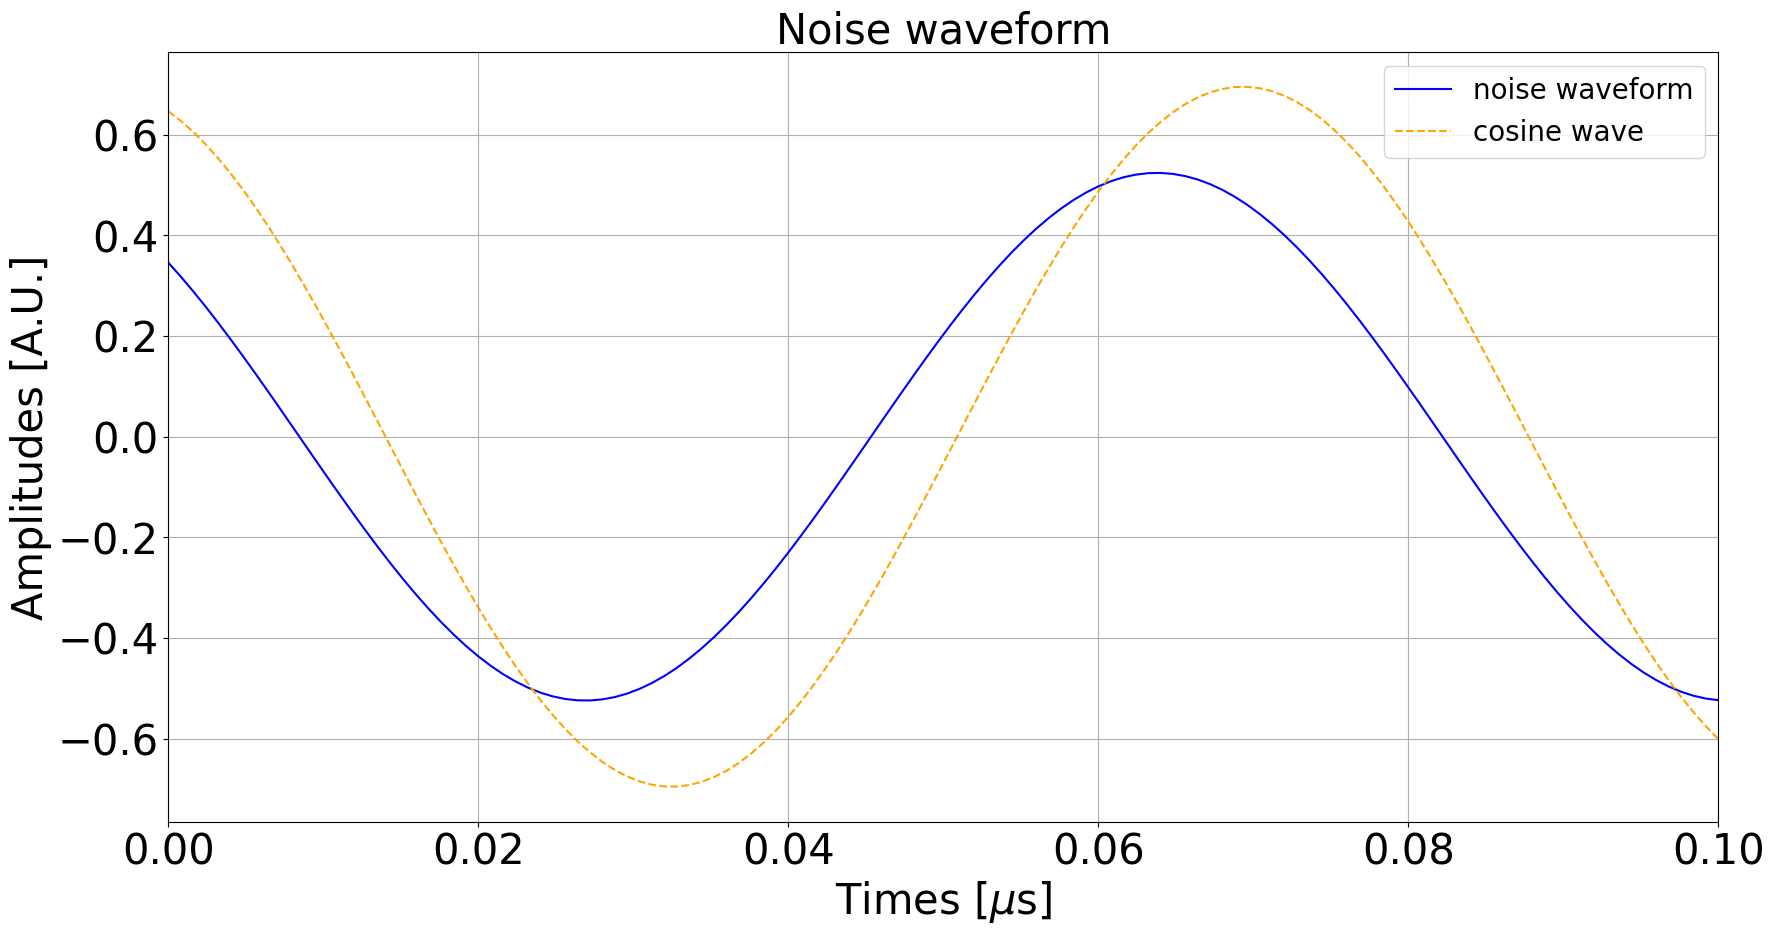

In [174]:
plt.figure(figsize=(20, 10))
#plt.errorbar(freqs, avg_fft_au, yerr = stds_fft, fmt='o', markersize = 2, ecolor='red', capsize = 3, capthick=1, elinewidth=1)
plt.plot(times, avg_noise_wf_corr, color = 'blue', label = 'noise waveform')
plt.plot(times, coswave, linestyle = '--', color = 'orange', label = 'cosine wave')

plt.title('Noise waveform', fontsize = 30)
plt.xlabel(r'Times [$\mu$s]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Amplitudes [A.U.]', fontsize = 30)
plt.yticks(fontsize = 30)
plt.grid(True)
plt.xlim(0, 0.1)
plt.legend(loc = 'best', fontsize = 20)

#plt.savefig("250724_17.23/fft.pdf", format = "pdf", bbox_inches="tight")
plt.show()


In [183]:
#???

## Compare to average waveform

In [175]:
#original_wf = fft.irfft(avg_fft_au) working in time domain, the original wf should not be the reconstructed one. But also, is the avg wf a good 'original wf'?
original_wf = np.mean(all_amplitudes, axis=0)

reconstructed_wf = fft.ifft(Ys, axis = 1)
avg_reconstructed_wf = np.mean(reconstructed_wf.real, axis = 0)

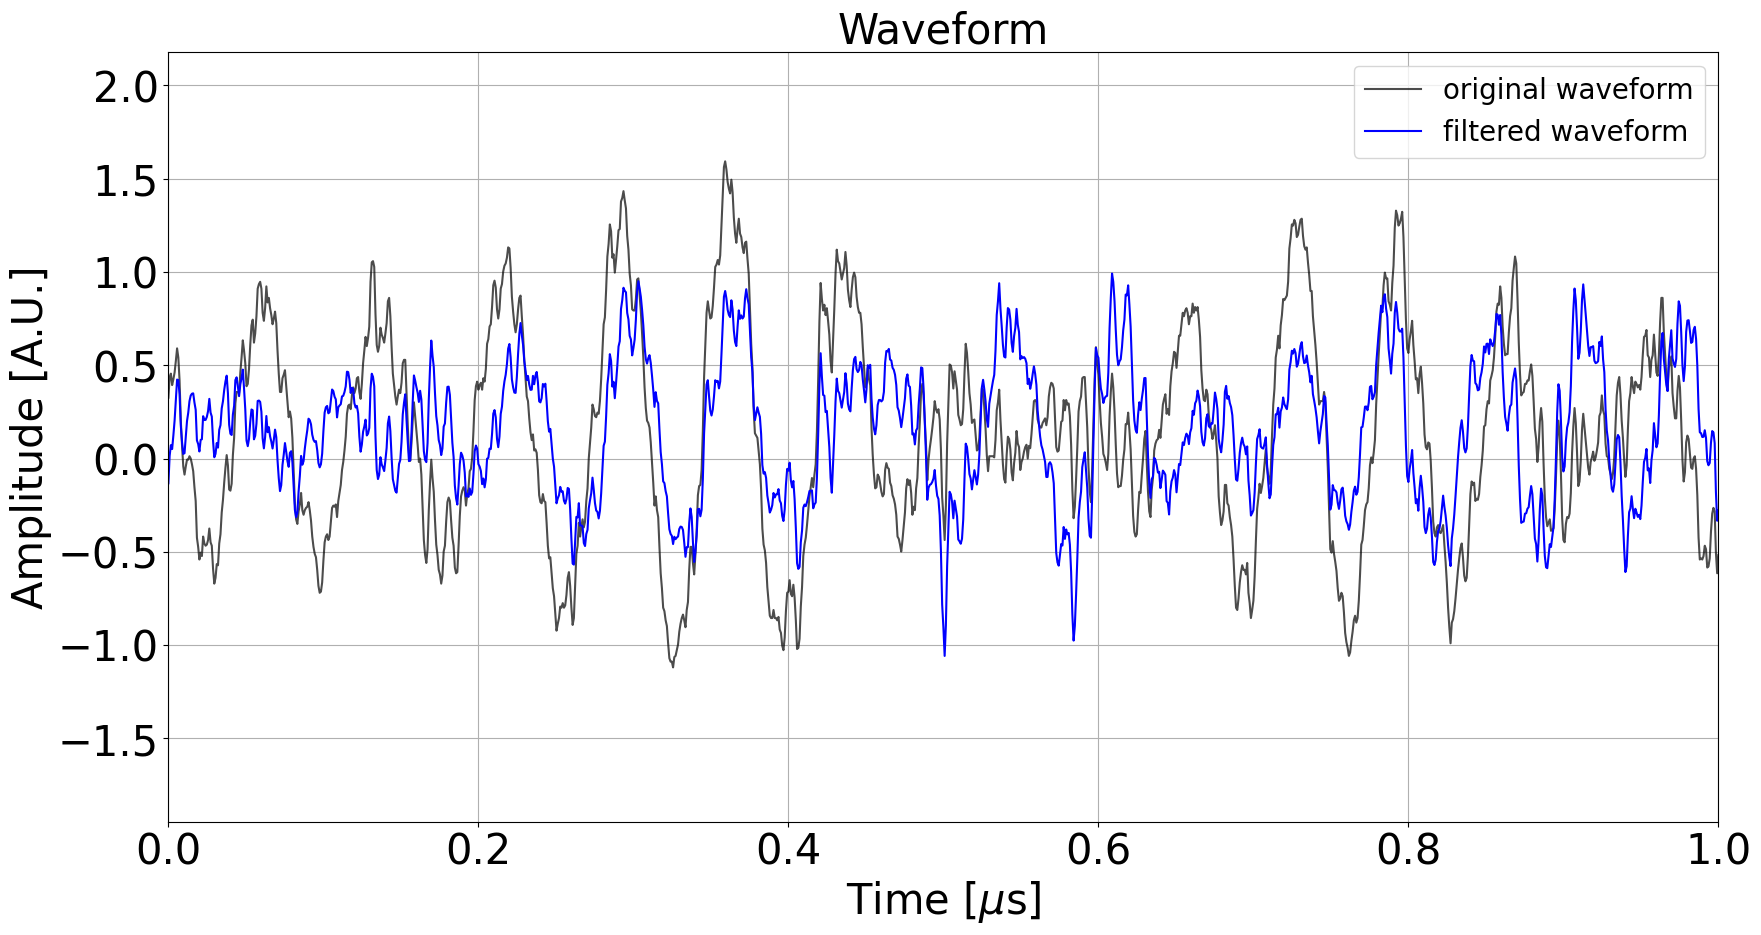

In [176]:
plt.figure(figsize = (20, 10))
plt.plot(times, avg_reconstructed_wf, label = 'original waveform', color = 'black', alpha = 0.7)
plt.plot(times, avg_reconstructed_wf - avg_noise_wf, label = 'filtered waveform', color = 'blue')

plt.title('Waveform', fontsize = 30)
plt.xlabel(r'Time [$\mu$s]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Amplitude [A.U.]', fontsize = 30)
plt.yticks(fontsize = 30)
plt.grid(True)
plt.xlim(0, 1)
plt.legend(loc = 'best', fontsize = 20)

#plt.savefig("Results/simple_ifft.png", format = "png", bbox_inches="tight")
#plt.savefig("Results/simple_ifft.pdf", format = "pdf", bbox_inches="tight")
plt.show()

In [177]:
filtered_wf = reconstructed_wf - avg_noise_wf

In [178]:
filtered_fft = fft.fft(filtered_wf)
all_filtered_phases = np.angle(filtered_fft)
avg_filtered_phases = np.mean(all_filtered_phases, axis = 0)
avg_filtered_fft = np.mean(np.abs(filtered_fft), axis = 0)

index = np.where(np.isclose(freqs, 13.55934897))[0]
phase_value = avg_filtered_phases[index]
print(phase_value)

[0.28007876]


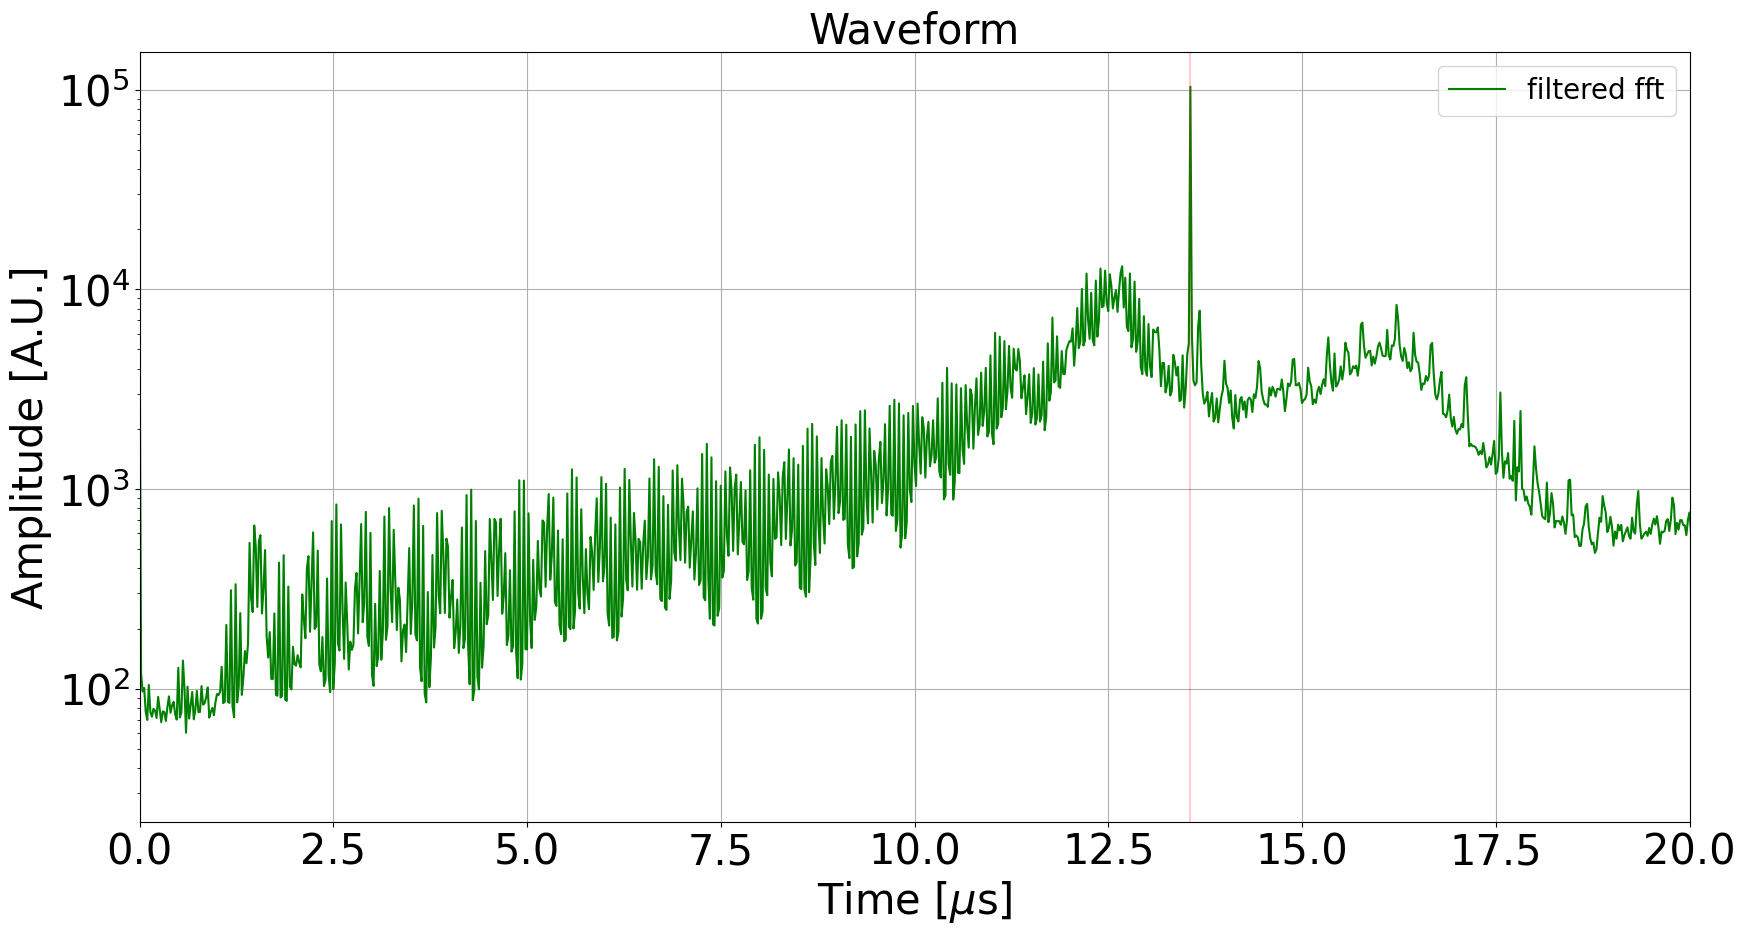

In [179]:
freqs = fft.fftshift(freqs)
avg_filtered_fft = fft.fftshift(avg_filtered_fft)
plt.figure(figsize = (20, 10))
plt.plot(freqs, avg_filtered_fft, label = 'filtered fft', color = 'green')
plt.axvline(13.55934897, color = 'red', alpha = 0.2)

plt.title('Waveform', fontsize = 30)
plt.xlabel(r'Time [$\mu$s]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Amplitude [A.U.]', fontsize = 30)
plt.yticks(fontsize = 30)
plt.semilogy()
plt.grid(True)
plt.xlim(f1, f2)
plt.legend(loc = 'best', fontsize = 20)

#plt.savefig("Results/simple_ifft.png", format = "png", bbox_inches="tight")
#plt.savefig("Results/simple_ifft.pdf", format = "pdf", bbox_inches="tight")
plt.show()

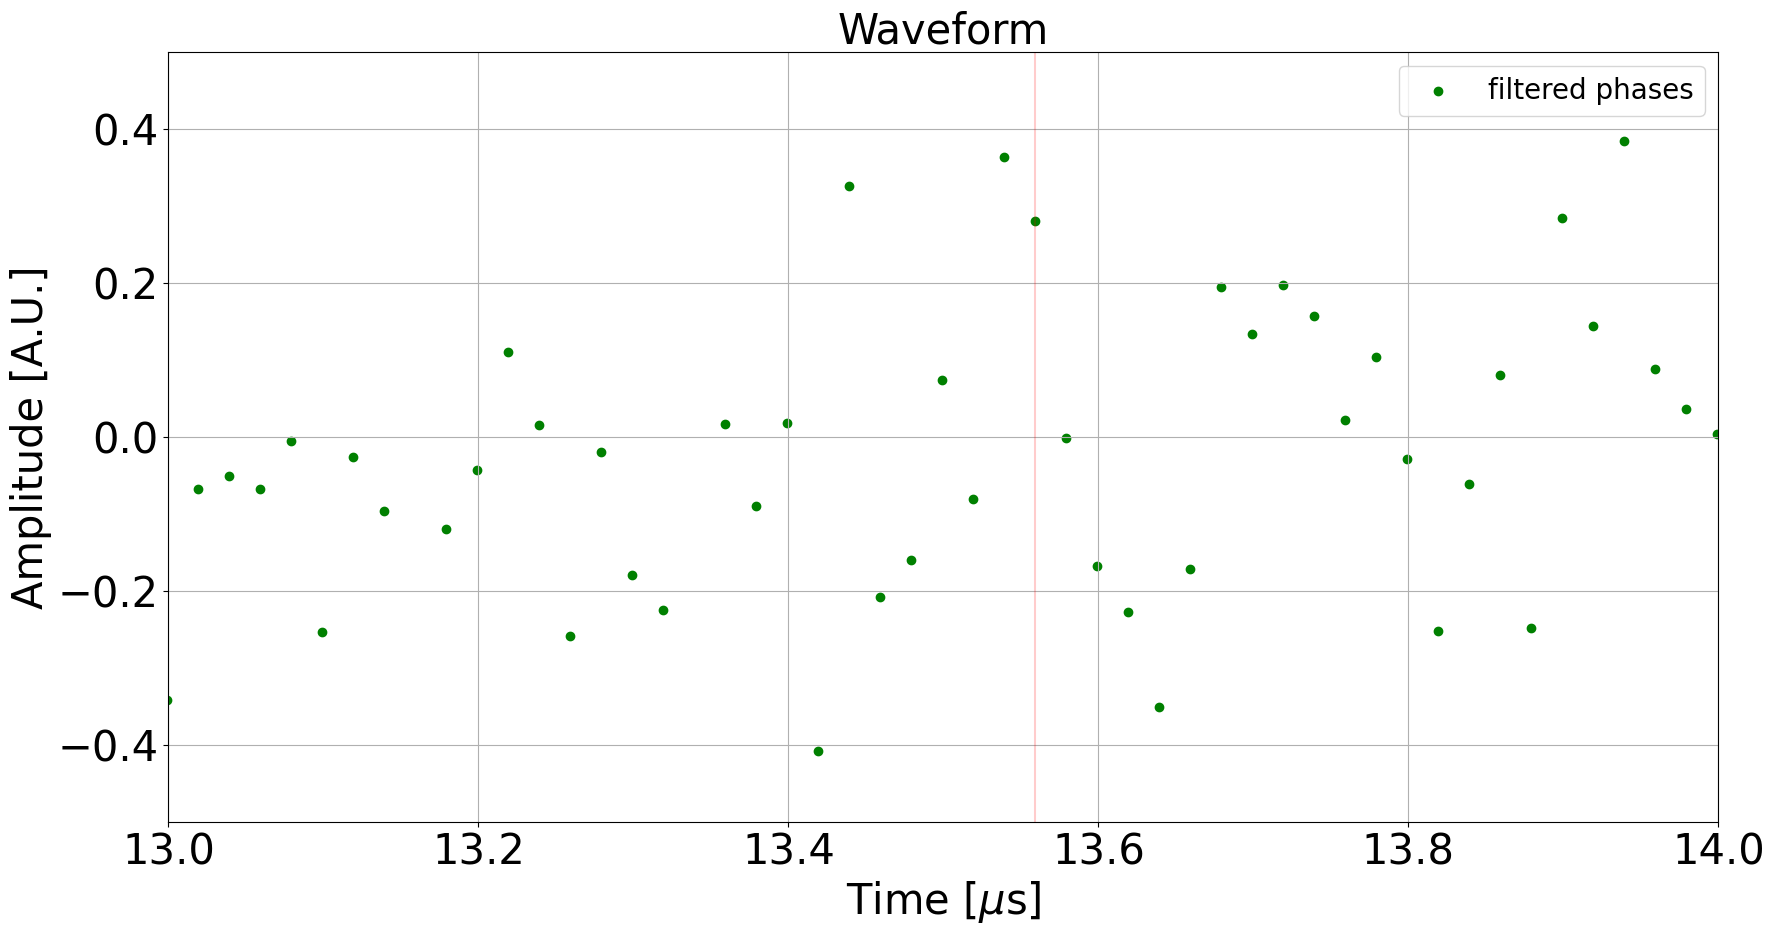

In [180]:
avg_filtered_phases = fft.fftshift(avg_filtered_phases)
plt.figure(figsize = (20, 10))
plt.scatter(freqs, avg_filtered_phases, label = 'filtered phases', color = 'green')
plt.axvline(13.55934897, color = 'red', alpha = 0.2)

plt.title('Waveform', fontsize = 30)
plt.xlabel(r'Time [$\mu$s]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Amplitude [A.U.]', fontsize = 30)
plt.yticks(fontsize = 30)
plt.grid(True)
plt.xlim(13, 14)
plt.ylim(-0.5, 0.5)
plt.legend(loc = 'best', fontsize = 20)

#plt.savefig("Results/simple_ifft.png", format = "png", bbox_inches="tight")
#plt.savefig("Results/simple_ifft.pdf", format = "pdf", bbox_inches="tight")
plt.show()

In [181]:
index = np.where(np.isclose(freqs, 13.55934897))[0]
phase_value = avg_filtered_phases[index]
print(phase_value)

[0.28007876]


In [182]:
#Inconsistent Phase Across Frequency Components: When you zero out parts of the FFT, you are altering the phase of the remaining components. If you don’t handle this correctly, it can lead to sudden phase shifts when transforming back to the time domain.
#fix the phase info thing